In [1]:
import matplotlib.pyplot as plt
import numpy as np
from homography import pyrs12, spaces
import deproject
import h5py
import cv2
import pptk
from sklearn.cluster import KMeans

In [2]:
!ls ../recording_data

Vhdf5_20181112_165607.hdf5 backup


In [3]:
data = h5py.File('../recording_data/Vhdf5_20181112_165607.hdf5', 'r')

In [4]:
data['IR'][70].shape

(480, 640)

In [5]:
imgc = data['color'][70][...,::-1]
imgIR = data['IR'][70]
#img = cam.color
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [6]:
def show_frame(one, two):
    fig1 = plt.figure(figsize=(15,15))
    ax1 = fig1.add_subplot(121)
    ax2 = fig1.add_subplot(122)
    ax1.imshow(one)
    ax2.imshow(two, cmap='gray')
    ax1.set_title('Color')
    ax2.set_title('binary')

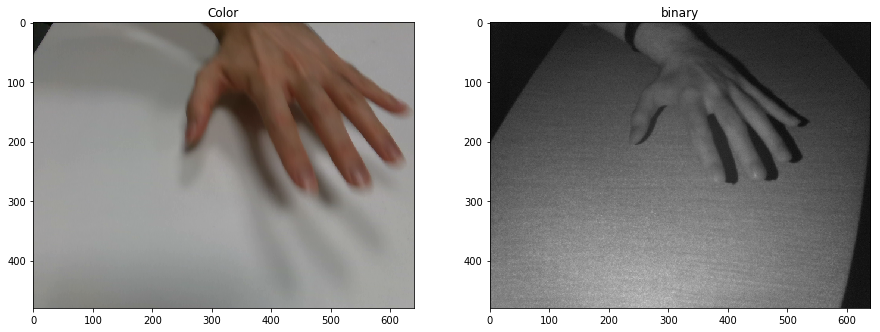

In [7]:
show_frame(imgc, imgIR)

In [8]:
blurc = cv2.GaussianBlur(imgc,(25,25),0)
blurIR = cv2.GaussianBlur(imgIR,(25,25),0)

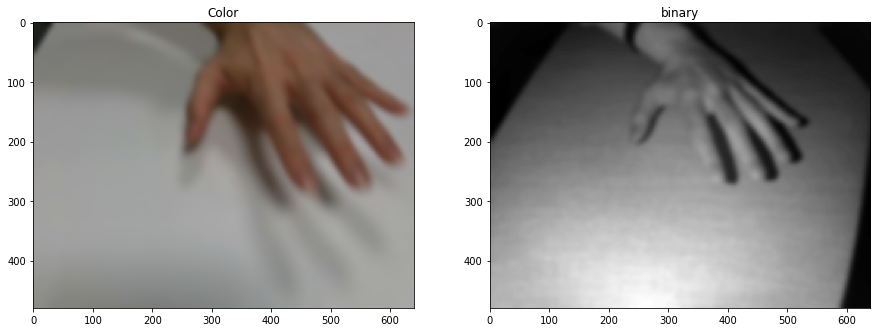

In [9]:
show_frame(blurc, blurIR)

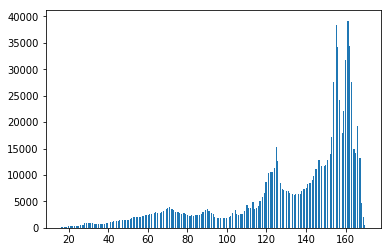

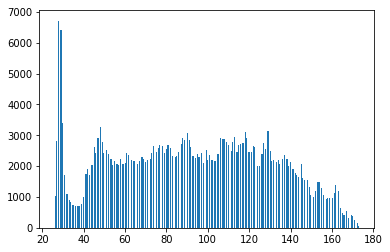

In [10]:
a = plt.hist(blurc.ravel(),256)
plt.show()
a = plt.hist(blurIR.ravel(),256)

In [11]:
ret,threshold = cv2.threshold(cv2.cvtColor(blurc, cv2.COLOR_BGR2GRAY),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

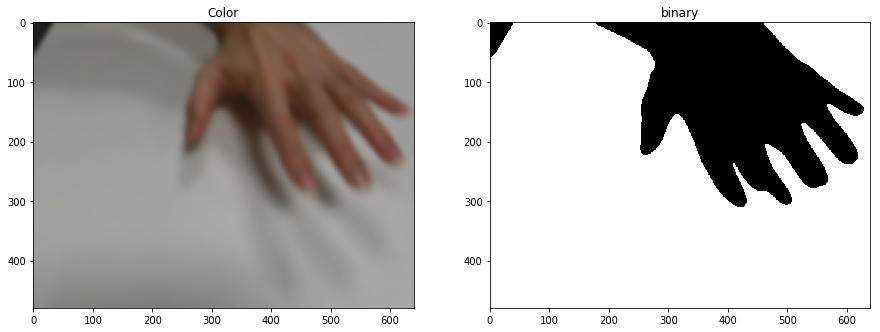

In [12]:
show_frame(blurc, threshold)

In [13]:
im2, contours, hierarchy=cv2.findContours(threshold,2,1)

In [14]:
len(contours)

1

In [15]:
imgc.shape

(480, 640, 3)

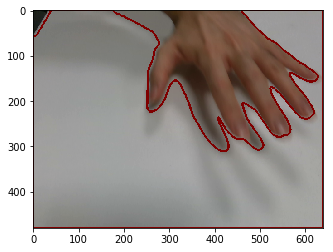

In [16]:
plt.imshow(cv2.drawContours(imgc.astype(np.int8), contours, -1, (255,0,0), 4).astype(np.uint8()))

In [17]:
# hull=cv2.convexHull(contours,returnPoints=False)
# defects=cv2.convexityDefects(contours,hull)

In [18]:
point = deproject.compute(data['depth'][0].astype(np.short()))
org = data['pcl_center'][...]
mat = data['trans_matrix'][...]
point = np.dot(mat, (point - org).reshape((-1,3)).T).T.reshape((480, 640, 3))

In [19]:
def apply_1c_mask_to_3c_pointcloud(mask,point):
    new = np.copy(point)
    new[:,:,0] = np.where(mask,point[:,:,0], 0)
    new[:,:,1] = np.where(mask,point[:,:,1], 0)
    new[:,:,2] = np.where(mask,point[:,:,2], 0)
    return new

In [20]:
table = apply_1c_mask_to_3c_pointcloud(point[:,:,2]>0, point)
CLOUD_UPPER_MIN = 0.02  # 1cm, which exclude the plane
CLOUD_UPPER_MAX = 0.10  # 10cm

## split in 2 clouds Low and High
zm_upper_min = point[:,:,2] > CLOUD_UPPER_MIN
zp_upper_max = point[:,:,2] < CLOUD_UPPER_MAX
cloud_upper = zm_upper_min & zp_upper_max

In [21]:
upper = apply_1c_mask_to_3c_pointcloud(cloud_upper, point)

In [25]:
v = pptk.viewer(point)

In [23]:
v = pptk.viewer(table)

In [24]:
v = pptk.viewer(upper)

## conflict
point cloud have show the point that do not exist in the depth hraph

In [94]:
hand = np.where(cloud_upper,255,0).astype(np.uint8)

In [95]:
unique, counts = np.unique(hand, return_counts=True)
print(dict(zip(unique, counts)))
counts[1]/counts[0]

{0: 307200}


IndexError: index 1 is out of bounds for axis 0 with size 1

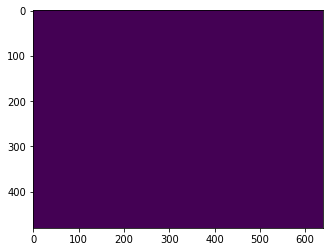

In [96]:
plt.imshow(hand)

In [97]:
blur = np.where(cv2.GaussianBlur(hand,(9,9),0).astype(np.uint8)>250,hand,0)

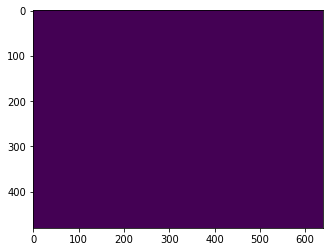

In [98]:
plt.imshow(blur)

In [99]:
im2, contours, hierarchy=cv2.findContours(blur, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

In [100]:
h, w = hand.shape

In [101]:
len(contours)

0

In [102]:
contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
contours[0]

IndexError: list index out of range

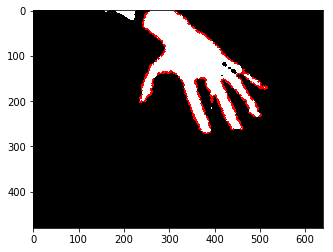

In [34]:
plt.imshow(cv2.drawContours(cv2.cvtColor(blur, cv2.COLOR_GRAY2RGB), contours[0], -1, (255,0,0), 3))

In [35]:
hull=cv2.convexHull(contours[0],returnPoints=True)

In [36]:
hull

array([[[516, 170]],

       [[503, 231]],

       [[502, 232]],

       [[461, 262]],

       [[384, 271]],

       [[380, 271]],

       [[375, 269]],

       [[236, 202]],

       [[236, 195]],

       [[242,  26]],

       [[244,  19]],

       [[248,   9]],

       [[256,   0]],

       [[314,   0]],

       [[335,  17]],

       [[378,  53]],

       [[516, 169]]], dtype=int32)

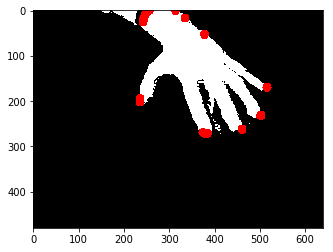

In [37]:
plt.imshow(cv2.drawContours(cv2.cvtColor(hand, cv2.COLOR_GRAY2RGB), hull, -1, (255,0,0), 20))

In [38]:
hull = np.sort(hull, axis=1)

In [39]:
hull

array([[[516, 170]],

       [[503, 231]],

       [[502, 232]],

       [[461, 262]],

       [[384, 271]],

       [[380, 271]],

       [[375, 269]],

       [[236, 202]],

       [[236, 195]],

       [[242,  26]],

       [[244,  19]],

       [[248,   9]],

       [[256,   0]],

       [[314,   0]],

       [[335,  17]],

       [[378,  53]],

       [[516, 169]]], dtype=int32)

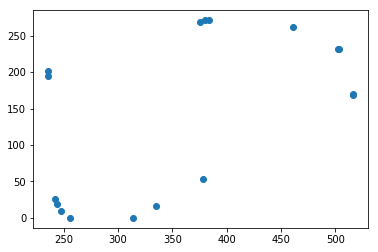

In [40]:
plt.scatter(hull[:,:,0],hull[:,:,1])

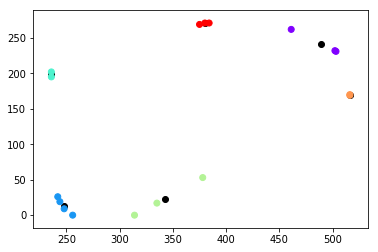

In [41]:
non = np.concatenate((hull[:,:,0],hull[:,:,1]),axis=1)
clusters = 6
kmeans = KMeans(n_clusters=clusters)  
kmeans.fit(non) 

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], color='black')
plt.scatter(hull[:,:,0].ravel(),hull[:,:,1].ravel(), c=kmeans.labels_, cmap='rainbow')  

In [42]:
c_point = kmeans.cluster_centers_.reshape(clusters, 1, 2).astype(np.int32)

In [43]:
print(hull.shape,hull.dtype)
print(c_point.shape,c_point.dtype)

(17, 1, 2) int32
(6, 1, 2) int32


## kmean doesn't work

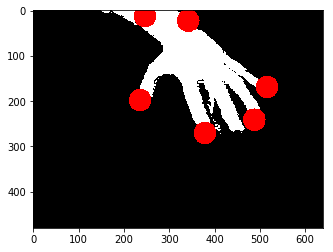

In [44]:
plt.imshow(cv2.drawContours(cv2.cvtColor(hand, cv2.COLOR_GRAY2RGB), c_point, -1, (255,0,0), 50))

## by distinct
clusting the point by distance threshold

In [45]:
hull2point = hull.reshape(17,2)
hull_vector = cv2.convexHull(contours[0],returnPoints=False)

In [46]:
non_zero_y = hull2point[hull2point[:,1]!=0]
non_zero = non_zero_y[non_zero_y[:,0]!=0]
hull_vector = hull_vector[hull2point[:,1]!=0][non_zero_y[:,0]!=0]

In [47]:
len(hull_vector)

15

In [48]:
len(non_zero)

15

In [49]:
def distance(p1, listOfpoint, threshold=15):
    p1 = np.array(p1)
    listOfpoint = np.array(listOfpoint)
    result = np.sum(np.power(listOfpoint-p1,2),axis =1)
    return  result < threshold*threshold

In [50]:
distance([2,2],[[np.inf,np.inf],[np.inf,np.inf]])

array([False, False])

In [51]:
np.full(len(non_zero), 0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [52]:
def contours_d(point, fun):
    cluster_label = np.full(len(non_zero), 0)
    cluster_counter = 0
    for i in range(len(point)):
        if(cluster_label[i]!=0):
            continue
        cluster_counter += 1
        cluster_label[i] = cluster_counter
        d_2all = distance(point[i], point)
        for i2 in range(len(d_2all)):
            if(d_2all[i2]):
                if(cluster_label[i2]!=0):
                    continue
                cluster_label[i2] = cluster_counter
        
    return cluster_label, cluster_counter

In [53]:
cluster_label, cluster_counter = contours_d(non_zero, distance)

In [54]:
result = np.concatenate((non_zero,cluster_label.reshape(len(cluster_label),1)),axis=1)
result_vector = np.concatenate((hull_vector,cluster_label.reshape(len(cluster_label),1)),axis=1)

In [55]:
result_vector

array([[674,   1],
       [580,   2],
       [579,   2],
       [447,   3],
       [280,   4],
       [279,   4],
       [275,   4],
       [123,   5],
       [122,   5],
       [ 16,   6],
       [ 12,   6],
       [  4,   7],
       [776,   8],
       [748,   9],
       [675,   1]])

In [56]:
result[result[:,2]==4]

array([[384, 271,   4],
       [380, 271,   4],
       [375, 269,   4]])

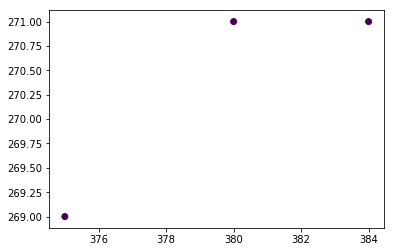

In [57]:
plt.scatter(result[result[:,2]==4][:,0],result[result[:,2]==4][:,1], c=[float(i) /10 for i in result[result[:,2]==4][:,2]])  

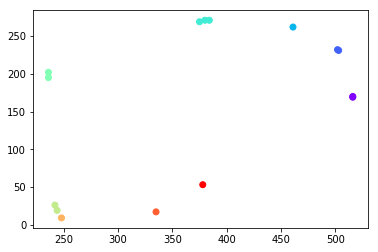

In [58]:
plt.scatter(result[:,0],result[:,1], c=[float(i) *100 for i in cluster_label], cmap='rainbow')  

In [59]:
np.mean(result[result[:,1]==1],axis=0)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


array([nan, nan, nan])

In [60]:
result = np.concatenate((non_zero,cluster_label.reshape(len(cluster_label),1)),axis=1)
def vstack_point(array, start, end):
    if start==end:
        return np.mean(array[array[:,2]==start],axis=0).astype(np.int32).reshape(1,3)
    return np.concatenate((np.mean(array[array[:,2]==start],axis=0).astype(np.int32).reshape(1,3),vstack_point(array, start+1,end)) , axis=0)


def vstack_vector(array, start, end):
    if start==end:
        return np.mean(array[array[:,1]==start],axis=0).astype(np.int32).reshape(1,2)
    return np.concatenate((np.mean(array[array[:,1]==start],axis=0).astype(np.int32).reshape(1,2),vstack_vector(array, start+1,end)) , axis=0)

clusted_vector = vstack_vector(result_vector, 1,cluster_counter)

clusted_point = vstack_point(result, 1 ,cluster_counter)[:,:2]
clusted_point_pint = vstack_point(result, 1 ,cluster_counter)[:,:2].reshape(cluster_counter,1,2)

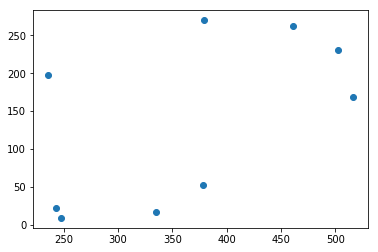

In [61]:
plt.scatter(clusted_point[:,0],clusted_point[:,1])  

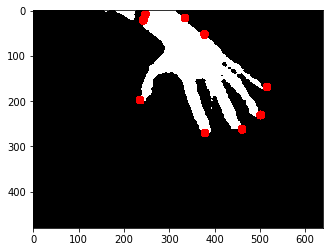

In [62]:
plt.imshow(cv2.drawContours(cv2.cvtColor(blur, cv2.COLOR_GRAY2RGB), clusted_point_pint, -1, (255,0,0), 20))

In [63]:
defects = cv2.convexityDefects(contours[0],clusted_vector[:,0])

In [64]:
defects

array([[[  674,   748,   698,  1834]],

       [[  748,   776,   759,  1452]],

       [[  776,     4,   787,  3841]],

       [[    4,    14,     5,   162]],

       [[   14,   122,    61, 12937]],

       [[  122,   278,   188, 21926]],

       [[  278,   447,   349, 31004]],

       [[  447,   579,   518, 29020]],

       [[  579,   674,   638, 18310]]], dtype=int32)

In [65]:
defects.shape

(9, 1, 4)

In [66]:
contours[0].shape

(788, 1, 2)

In [67]:
blur2 = cv2.cvtColor(blur, cv2.COLOR_GRAY2RGB)
for i in range(defects.shape[0]):
    s,e,f,d = defects[i,0]
    start = tuple(contours[0][s][0])
    end = tuple(contours[0][e][0])
    far = tuple(contours[0][f][0])
    cv2.line(blur2,start,end,[0,255,0],2)
    cv2.circle(blur2,far,5,[255,0,0],20)

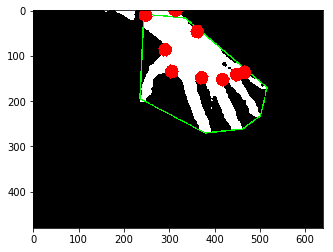

In [68]:
plt.imshow(blur2)

In [69]:
maping = dict()
hall_index = np.concatenate((defects[:,0,0],defects[:,0,1]))
hall_index

array([674, 748, 776,   4,  14, 122, 278, 447, 579, 748, 776,   4,  14,
       122, 278, 447, 579, 674], dtype=int32)

In [70]:
defects

array([[[  674,   748,   698,  1834]],

       [[  748,   776,   759,  1452]],

       [[  776,     4,   787,  3841]],

       [[    4,    14,     5,   162]],

       [[   14,   122,    61, 12937]],

       [[  122,   278,   188, 21926]],

       [[  278,   447,   349, 31004]],

       [[  447,   579,   518, 29020]],

       [[  579,   674,   638, 18310]]], dtype=int32)

In [71]:
for i in hall_index:
    maping[i] = []

In [72]:
for i in range(defects.shape[0]):
    s,e,f,d = defects[i,0]
    maping[s].append(f)
    maping[e].append(f)

In [73]:
contours[0][674][0]

array([516, 170], dtype=int32)

In [74]:
dd_vector = np.array(list(maping.values()))##list of defects
hall_vector = defects[:,0,0]
##defect defect
#hall
dd_vector.shape

(9, 2)

In [75]:
hall_vector.shape

(9,)

In [76]:
contours[0][dd_vector][:,:,0].shape

(9, 2, 2)

In [77]:
contours[0][hall_vector][:,0].shape

(9, 2)

In [78]:
dd_point = contours[0][dd_vector][:,:,0]
hall_point = contours[0][hall_vector][:,0]

In [81]:
np.sum(np.power(dd_point[:,0]-dd_point[:,1],2),axis =1)

array([  314, 18916,  4513,  4477,  7625,  2529,  4552,  2132,  1082])

<img src="https://www.mathwarehouse.com/trigonometry/images/law-of-cosines/law-of-cosines-formula-and-picture2.webp">

In [82]:
##cosine law  cos(A) = (b^2+c^2-a^2)/(2bc)
Ap = hall_point
Bp = dd_point[:,0]
Cp = dd_point[:,1]
##sqrt((p1-p2)**2)
a_distance = np.sum(np.power(Bp-Cp,2),axis =1)
b_distance = np.sum(np.power(Ap-Cp,2),axis =1)
c_distance = np.sum(np.power(Ap-Bp,2),axis =1)
Angel_A = np.arccos((b_distance + c_distance - a_distance)/(2 * np.sqrt(b_distance) * np.sqrt(c_distance))) * (180 / np.pi)

In [83]:
Angel_A

array([ 10.74425158, 156.88826507, 170.97820654,  97.76516602,
       121.6585407 ,  22.41081477,  25.09095409,  16.69533695,
        16.26362991])

In [84]:
isfinger = Angel_A < 60

In [85]:
hall_point[isfinger].reshape(5,1,2)

array([[[516, 170]],

       [[236, 195]],

       [[379, 270]],

       [[461, 262]],

       [[502, 232]]], dtype=int32)

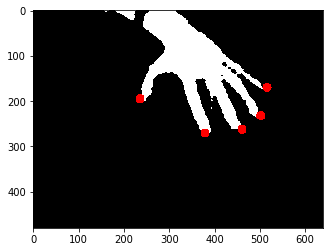

In [86]:
plt.imshow(cv2.drawContours(cv2.cvtColor(blur, cv2.COLOR_GRAY2RGB), hall_point[isfinger].reshape(5,1,2), -1, (255,0,0), 20))